# Beta-Gamma Monte Carlo Particle Simulation in Cylindrical Volume

This tutorial will show how to implement Monte Carlo particle simulation for a simple case. In this case, a cylindrical tank filled with radiation source, as in liquid scintillator. We assign the upper lid as the detector or the place in which passed radiations will be counted. In this system, we assume that the detector is very efficient and the limitation of detection only comes from the geometry and beta mean free path. The mean free path inside this medium is assumed by user input to simplify the simulation of charged particle simulation.

In [1]:
from random import random, choices
from math import pi, sin, cos, log, acos
from matplotlib import pyplot as plt

import plotly.graph_objects as go
import plotly.io as pio
import time

import sys


## 1. Utility function

First, let's define some utility function that can be used in each particle interaction function such as: Gamma Cross Section table reader, Interpolation of any variable as function of energy, and print-plot particle trace.

### 1.a. Gamma $\sigma$ Table Reader

This function used to open ASCII file contained gamma cross section table. The data can be copy-pasted from this [reference](https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html). Table format also follows the [reference](https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html) with any desired delimiter/**sep** (by default is *tab*).

In [2]:
def read_gamma_CS(filename,sep = '\t'):
    CS = {'Energy':[],'Coherent':[],'Incoherent':[],'Photoelectric':[],
          'Nuclear Pair Production':[],'Electron Pair Production':[],
          'Total w/ Coherent':[],'Total wo/ Coherent':[]}
    with open(filename) as f:
        for n,line in enumerate(f):
            if n > 2 and line!='\n':
                for i in range(0,8):
                    CS[list(CS.keys())[i]] += [float(line.split(sep=sep)[i])]
    return CS

### 1.b. Interpolation

This function will perform linear interpolation used mainly for cross section data.

$\sigma(E) = \dfrac{E-E_d[i]}{E_d[j]-E_d[i]}(\sigma[j]-\sigma[i])+\sigma[i]$

In [3]:
def Interpolate(D,E,column):
    i=1
    while E-D['Energy'][i]>=0:
        i+=1
    j=i-1
    intpl = (E-D['Energy'][i])/(D['Energy'][j]-D['Energy'][i])*(D[column][j]-D[column][i])+D[column][i]
    return intpl

### 1.c. Print

This function will print the radiation path trace information such as starting point (x,y,z), Energy (E), mean free path (l), particle type (p: b+, b- or g), Interaction process (C)

In [4]:
def print_out(Collection,n):
    for j in range(0,len(Collection[n])):
        if j==0:
            print('\n|================================== Particle '+str(n)+' ===============================|\n'+
                  ' hit\t'+" x\t\t\t"+"y\t\t\t"+"z\t\t\t"+"E\t\t\t"+"lambda\t\t"+" particle\t"+"\n"+
                  '|===|===========|============|===========|===========|=============|==========|')     
        print(j,'\t',
              "{:.3e}\t".format(Collection[n][j]['x']),
              "{:.3e}\t".format(Collection[n][j]['y']),
              "{:.3e}\t".format(Collection[n][j]['z']),
              "{:.3e}\t".format(Collection[n][j]['E']),
              "{:.3e}\t".format(Collection[n][j]['l']),
              (Collection[n][j]['p']),'\t',
              '\t  ',(Collection[n][j]['C']))
    Trace = [go.Scatter3d(x=[Collection[n][j]['x'] for j in range(0,len(Collection[n]))],
                          y=[Collection[n][j]['y'] for j in range(0,len(Collection[n]))],
                          z=[Collection[n][j]['z'] for j in range(0,len(Collection[n]))],
                          marker= dict(size=2),
                          line  = dict(color='darkblue',width=1))]
    return Trace

### 1.d. Plot
This function used to draw 3D interactive plot of radiation path inside cylinder using [Plotly](https://plotly.com/) package. The trace is returned from *print_out*.

In [5]:
def Plot(P,BB,renderer = 'notebook_connected',Trace = []):
    H1,H2,r,a,b = P
    
    import numpy as np
    pio.renderers.default = renderer
    
    xa = [r*cos(2*pi*i/100)+a for i in range(0,100)]
    ya = [r*sin(2*pi*i/100)+b for i in range(0,100)]
    Trace += [go.Scatter3d(x = xa+[None]+xa,
                          y = ya+[None]+xa,
                          z = [H1]*100+[None]+[H2]*100,
                          mode = 'lines',line = dict(color='black', width=1),
                          showlegend = False)]
    th, v = np.meshgrid(np.linspace(0,2*pi,100),np.linspace(H2,H1,50))
    Trace+= [go.Surface(x = r*np.cos(th),y = r*np.sin(th),z = v,
                        opacity=0.2,showlegend = False,showscale=False)]
    
    fig = go.Figure(Trace)
    fig.update_layout(scene=dict(xaxis=dict(range=BB[0]),yaxis=dict(range=BB[1]),
                                 zaxis=dict(range=BB[2])),
                      scene_aspectmode='cube',showlegend=False)
    fig.layout.scene.camera.projection.type = "orthographic"
    fig.show()

## 2. Geometry

Next, we define the Cylinder, perpendicular to Z axis, boundary surface with base at H2, roof at H1, radius at r, and center axis (a,b). Points inside the cell defined by these criteria:

$(x-a)^2+(y-b)^2-r^2\leq0$
        
$z\leq H2$
        
$z > H1$
        
If (x,y,z) arbitrary point agree with the criteria, it will return -1 or else. 

In [6]:
def Finite_Cylinder(P,C):
    H1,H2,r,a,b = P
    x,y,z       = C
    if (x-a)**2+(y-b)**2-r**2 <= 0 and z < H2 and z >= H1:
        p = -1
    else:
        p = 1
    return p

## 3. Volumetric Source

As initiation of the simulation, we need to initiate some point inside the system as our source. Since the radiation source dissolved, the source particle can be modelled as isotropic source at a random point. The point will be tested with **Finite_Cylinder**, if it inside then it accepted and else will not be considered. It will loop until all particle initiated.

If the particle is beta, then the program will randomize the mean free path using exponential distribution. 

$-\lambda\ ln(1-y) = x$

$y^{-1} = -\lambda\ ln(1-rand())$

If the particle is $\gamma$, then, the program will linearly interpolate the Cross Section ($\sigma$) data to get total cross section ($\sigma_{total}$) for the initial energy. The $\sigma$.

$\lambda = \dfrac{1}{\sigma_{total}[cm^2/g]\ \rho[g/cm^3]}$

In [7]:
def Volumetric_Source(N,E,P,L,particle,CS,rho):
    Collection  = []
    H1,H2,r,a,b = P
    while len(Collection)<N:
        pt,pr = [random()*2*pi,random()*r]
        x,y,z = [pr*cos(pt),pr*sin(pt),random()*(H2-H1)+H1]
        Check = Finite_Cylinder(P,[x,y,z])
        
        if Check <= 0:
            if particle == 'b+' or particle == 'b-':
                l   = -L*log(1-random())
            elif particle == 'g':
                l   = 1/(Interpolate(CS, E, 'Total wo/ Coherent')*rho)
            Collection += [[{'x':x,'y':y,'z':z,'E':E,'l':l,'C':'initial','p':particle}]]
    return Collection


## 4. Particle Interaction

We have two types of particle to simulate, thus here the interaction function for both of them.



### 4.2. Beta Interaction

For simplification, we will not simulate all the path of beta particle due to various stopping interaction. Instead, we only calculate the track as single path with mean free path as the track length. Once it reach the track length, it become stable or at rest. If the particle is $\beta^{+}$, then the program will add particle using the Positron Annihilation function, or else the particle will be considered as stable. At the end of the calculation, the data will be collected into dictionary (named list).

In [8]:
def Beta_Interaction(Collection,n,P,CS,rho,L,**kwargs):
    ps = random()*2*pi
    pt = random()*2*pi
    H1,H2,r,a,b = P
    l           = Collection[n][-1]["l"]
    x,y,z= [Collection[n][-1]["x"]+Collection[n][-1]["l"]*sin(ps)*cos(pt),
            Collection[n][-1]["y"]+Collection[n][-1]["l"]*sin(ps)*sin(pt),
            Collection[n][-1]["z"]+Collection[n][-1]["l"]*cos(ps)]
    if Finite_Cylinder(P,[x,y,z]) <= 0:
        if Collection[n][-1]["p"] == 'b+':
            com = 'annihilation'
            Collection = Positron_Annihilation(Collection,n,P,CS,rho)
        else:
            com = 'stable'
    elif (z >= H2 and (x-a)**2+(y-b)**2-r**2 < 0):
        com = 'detected'
    else:
        com = 'leak'
    Collection[n] += [{'x':x,'y':y,'z':z,'E':0,'l':l,'C':com,
                       'p':Collection[n][-1]['p']}]
    return Collection

### 4.b. Positron Annihilation

If positron at rest, it will interact with electron and will form two gamma with energy of 0.511 MeV (electron mass at rest). This interaction is called annihilation. These gammas will also interact with medium until it absorbed due to photoelectric interaction. Gammas from annihilation is emitted back to back with the angle between two gamma path is 180$^{\circ}$.

In the code, we took the last point of beta that has been annihilated as (x0,y0,z0). By knowing the energy of gamma, we can interpolate the cross section data to obtain the mean free path. The final path of the first annihilation gamma will be determined randomly. Since the gammas emitted back to back, the second gamma will have negative mean free path. Then, we check if both gammas is inside the system, detected or leak using the parametric equation of cylinder. The code will store two path for each gamma particle to be simulated in run sequence.

In [9]:
def Positron_Annihilation(Collection,n,P,CS,rho):
    ps          = random()*2*pi
    pt          = random()*2*pi
    H1,H2,r,a,b = P
    l1          = 1/(Interpolate(CS, 0.511, 'Total wo/ Coherent')*rho)    
    x1,y1,z1,e1 = [Collection[n][-1]['x'],
                   Collection[n][-1]['y'],
                   Collection[n][-1]['z'],0.511]
    
    x2,y2,z2 = [x1 + l1*sin(ps)*cos(pt),
                y1 + l1*sin(ps)*sin(pt),
                z1 + l1*cos(ps)]
    if Finite_Cylinder(P, [x2,y2,z2]) <= 0:
        com2  = 'Travel'
    elif (z2 >= H2 and (x2-a)**2+(y2-b)**2-r**2 < 0):
        com2  = 'detected'
    else:
        com2  = 'leak'

    x3,y3,z3 = [x1 - l1*sin(ps)*cos(pt),
                y1 - l1*sin(ps)*sin(pt),
                z1 - l1*cos(ps)]
    if Finite_Cylinder(P, [x3,y3,z3]) <= 0:
        com3  = 'Travel'
    elif (z3 >= H2 and (x3-a)**2+(y3-b)**2-r**2 < 0):
        com3  = 'detected'
    else:
        com3  = 'leak'
        
    Collection += [[{'x':x1,'y':y1,'z':z1,'E':e1,'l':l1,'C':'annihilation','p':'g'},
                    {'x':x2,'y':y2,'z':z2,'E':0,'l':0,'C':com2,'p':'g'}],
                   [{'x':x1,'y':y1,'z':z1,'E':e1,'l':l1,'C':'annihilation','p':'g'},
                    {'x':x3,'y':y3,'z':z3,'E':0,'l':0,'C':com3,'p':'g'}]]
    return Collection

### 4.d Gamma Interaction

Simulating gamma particle is much more 
difficult than the beta in this problem. Gamma particle in this problem will interact with matter through photoelectric, Compton Scattering (Incoherent Scattering) and Nuclear Pair Production. Each interaction has its own function to calculate the mean free path and energy.

It start by path randomization. If the particle is an initial particle not from the positron annihilation, then it will use the initial energy. Else, then , the code will collect the last path energy to calculate the mean free path using the cross section data interpolation. In this condition, we consider that the particle scattered through Compton interaction.

To determine the interaction, we use weighted random choice function from python, with weight of each choice is the value of corresponding cross section. Once the choice made, if the choice is photoelectric, then the loop will stop and the particle is absorbed. If the choice is pair production it will produce two new beta particle. It the choice is Compton, then the particle move and loop continues.

In [10]:
def Gamma_Interaction(Collection,n,P,CS,rho,L):
    stop = False
    H1,H2,r,a,b = P
    while stop==False:
        ps = random()*2*pi
        pt = random()*2*pi
        if len(Collection[n]) == 1:
            e = Collection[n][-1]["E"]
        else:
            e = Compton(Collection, n, ps, pt)
            Collection[n][-1]['E'] = e
            Collection[n][-1]['l'] = 1/(Interpolate(CS,e,'Total wo/ Coherent')*rho)
        x,y,z= [Collection[n][-1]["x"]+Collection[n][-1]["l"]*sin(ps)*cos(pt),
                Collection[n][-1]["y"]+Collection[n][-1]["l"]*sin(ps)*sin(pt),
                Collection[n][-1]["z"]+Collection[n][-1]["l"]*cos(ps)]        
        if Finite_Cylinder(P,[x,y,z]) <= 0:
            CS_To = Interpolate(CS, e, 'Total wo/ Coherent')
            CS_PE = Interpolate(CS, e, 'Photoelectric')
            CS_IC = Interpolate(CS, e, 'Incoherent')
            CS_PP = Interpolate(CS, e, 'Nuclear Pair Production')
            chc   = choices(['Incoherent','Photoelectric','Nuclear Pair Production'],
                            weights=[CS_IC/CS_To,CS_PE/CS_To,CS_PP/CS_To],k=1)[0]
            Collection[n] += [{'x':x,'y':y,'z':z,'E':0,'l':0,'C':chc,'p':'g'}]
            if   chc == 'Photoelectric':
                stop = True
            elif chc == 'Nuclear Pair Production':
                Collection = Pair_Production(Collection,n,P,CS,rho,L)
                stop = True
            else:
                Collection[n][-1]['C'] = 'Travel'
        else:
            if (z >= H2 and (x-a)**2+(y-b)**2-r**2 < 0):
                com = 'detected'
            else:
                com = 'leak'
            Collection[n] += [{'x':x,'y':y,'z':z,'E':0,'l':0,'C':com,'p':'g'}]
            stop= True
    return Collection

### 4.e. Compton Scattering

Gamma particle will change its direction through Compton scattering. The Energy of Compton scattering depends on the initial energy and the direction of scattering. The direction of scattering ($v1$) itself can be calculated by two vector which are; the vector of initial path (last point in path substracted by the second last point in path) and the normal vector of the randomized direction. The ($v2$) vector of final gamma is randomized. The equation of final gamma Energy after Compton interaction is:

$\theta = acos\left(\dfrac{v1.v2}{||v1||\ ||v2||}\right)$

$E = \dfrac{E}{1+\dfrac{E}{0.511^2}(1-cos(\theta))}$

In [11]:
def Compton(Collection,n,ps,pt):
    x1,y1,z1 = Collection[n][-2]['x'],Collection[n][-2]['y'],Collection[n][-2]['z']
    x2,y2,z2 = Collection[n][-1]['x'],Collection[n][-1]['y'],Collection[n][-1]['z']
    
    v1 = [x2-x1,y2-y1,z2-z1]
    m1 = sum([i**2 for i in v1])**0.5
    v2 = [sin(ps)*cos(pt),sin(ps)*sin(pt),cos(ps)]; 
    m2 = sum([i**2 for i in v2])**0.5
    E  = Collection[n][-2]['E']
    
    costh = sum([i*j for i,j in zip(v1,v2)])/(m1*m2)
    th    = acos(costh)
    e     = E/(1+E/(0.511**2)*(1-cos(th)))
    return e

### 4.f. Pair Production

The key difference between annihilation and pair production is the particle type. When the pair production happen, two different charge produced which are $\beta^{+}$ and $\beta^{-}$. If these particle stay inside system after it travel as far as mean free path, then $\beta^{+}$ will annihilate and $\beta^{-}$ will be at rest (stable). When it annihilate, the code will trigger the Positron Annihilation for $\beta^{+}$ path.

In [12]:
def Pair_Production(Collection,n,P,CS,rho,L):
    ps          = random()*2*pi
    pt          = random()*2*pi
    H1,H2,r,a,b = P
    l1          = L    
    x1,y1,z1,e1 = [Collection[n][-1]['x'],
                   Collection[n][-1]['y'],
                   Collection[n][-1]['z'],
                   Collection[n][-2]['E']]
    
    x2,y2,z2 = [x1 + l1*sin(ps)*cos(pt),
                y1 + l1*sin(ps)*sin(pt),
                z1 + l1*cos(ps)]
    if Finite_Cylinder(P, [x2,y2,z2]) <= 0:
        com2  = 'stable'
    elif (z2 >= H2 and (x2-a)**2+(y2-b)**2-r**2 < 0):
        com2  = 'detected'
    else:
        com2  = 'leak'

    x3,y3,z3 = [x1 - l1*sin(ps)*cos(pt),
                y1 - l1*sin(ps)*sin(pt),
                z1 - l1*cos(ps)]
    if Finite_Cylinder(P, [x3,y3,z3]) <= 0:
        com3  = 'annihilation'
    elif (z3 >= H2 and (x3-a)**2+(y3-b)**2-r**2 < 0):
        com3  = 'detected'
    else:
        com3  = 'leak'
        
    Collection += [[{'x':x1,'y':y1,'z':z1,'E':e1/2,'l':l1,'C':'annihilation','p':'b-'},
                    {'x':x2,'y':y2,'z':z2,'E':0,'l':0,'C':com2,'p':'b-'}],
                   [{'x':x1,'y':y1,'z':z1,'E':e1/2,'l':l1,'C':'annihilation','p':'b+'},
                    {'x':x3,'y':y3,'z':z3,'E':0,'l':0,'C':com3,'p':'b+'}]]
    if com3 == 'annihilation':
        Collection = Positron_Annihilation(Collection, -1, P, CS, rho)
    return Collection

## 5. Main Program

Each of the interaction explained with flowchart in this problem was made into function (definition in python). Each of interaction will add new particle into the collection or only add new path to a particle depends on the random phenomenon. The main will only calculate the particle path if that particle is travelling or at initial position.

In [13]:
def Main_Program(r,L,h,E,N,rho,particle,dirpath,plot = False, prints=True):
    #start = time.time()
    #units in mm
    P = [0,h,r,0,0]

    CS  = read_gamma_CS(dirpath)

    Collection   = Volumetric_Source(N, E, P, L, particle, CS, rho)

    n=0; Trace = []
    while n<len(Collection):
        if (Collection[n][-1]['C'] == 'Travel' or
            Collection[n][-1]['C'] == 'initial'):
            if Collection[n][-1]['p'] == 'b+' or Collection[n][-1]['p'] == 'b-':
                Collection = Beta_Interaction(Collection, n, P, CS, rho, L)
            elif Collection[n][-1]['p'] == 'g':
                Collection = Gamma_Interaction(Collection, n, P, CS, rho, L)
        if prints == True:
            Trace += print_out(Collection,n)
        n+=1

    #print('Time Elapsed : ',time.time()-start,' s\n for simulating ',len(Collection),' particles')
    if plot == True:
        Plot(P,[[-r,r],[-r,r],[0,h]],Trace = Trace)
    return Collection

## 6. Test Simulation

Single $\gamma$ particle was simulated to check if the code and algorithm work as intended. The simulation geometry and parameter was adjusted to show clear path between different interaction. 

In this case we simulate gamma and do while loop until one of the gamma do pair production interaction. The medium in this case is made of water with 1 $g/cm^3$ density. The cylinder made quite high to accomodate the mean free path of gamma.

In [14]:
start = time.time()
#units in cm
L = 5               # Beta Mean Range [2]
H = 50              # Cylinder Height [0.5]
R = 80              # Radius of Cylinder [0.9]
E = 10              # Energy of beta/Gamma [2]
N = 2
particle = 'g'
rho      = 1         # Medium density [g/cm3]
dirpath  = 'H2O_CS'

Stop=False
while Stop==False:
    Collection = Main_Program(R,L,H,E,N,rho,particle,dirpath,prints=False)
    for part in Collection:
        if part[-1]['C'] == 'Nuclear Pair Production':
            Stop=True

print("\r", end="")
            
Trace = []
for n in range(0,len(Collection)):
    Trace += print_out(Collection,n)
P = [0,H,R,0,0]
Plot(P,[[-R,R],[-R,R],[0,H]],Trace = Trace)


|================================== Particle 0 ===============================|
 hit	 x			y			z			E			lambda		 particle	
|===|===========|============|===========|===========|=============|==========|
0 	 3.099e+01	 -5.707e+01	 4.954e+01	 1.000e+01	 4.507e+01	 g 	 	   initial
1 	 -2.726e-01	 -3.047e+01	 3.094e+01	 0.000e+00	 0.000e+00	 g 	 	   Nuclear Pair Production

|================================== Particle 1 ===============================|
 hit	 x			y			z			E			lambda		 particle	
|===|===========|============|===========|===========|=============|==========|
0 	 2.411e+01	 -6.595e+01	 1.391e+01	 1.000e+01	 4.507e+01	 g 	 	   initial
1 	 2.331e+01	 -2.126e+01	 1.969e+01	 0.000e+00	 0.000e+00	 g 	 	   Nuclear Pair Production

|================================== Particle 2 ===============================|
 hit	 x			y			z			E			lambda		 particle	
|===|===========|============|===========|===========|=============|==========|
0 	 -2.726e-01	 -3.047e+01	 3.094e+01	 5.000e+00	 5.000e+

## 6.a. Cases: $\beta^{+}$ simulation with heigt variation

The cylinder of our cell has 5 mm height and 9 mm radius. The $\beta^{+}$ mean free path is constant at $\lambda = 0.2 cm$. The energy is not important in here, since we are already provided with constant $\lambda$. The detector placed on top of the cylinder, thus, every radiation cross the top lid of cylinder considered as detected. The number of particle simulated is $10$. There are $10$ number of height variation simulated.

In [15]:
start = time.time()
#units in cm
L = 0.2              # Beta Mean Range [2]
H = 0.5              # Cylinder Height [0.5]
R = 0.9              # Radius of Cylinder [0.9]
E = 2                # Energy of beta/Gamma [2]
N = 10              # Number of particle simulated
particle = 'b+'
rho      = 1         # Medium density [g/cm3]
dirpath  = 'H2O_CS'
n = 10               # Number of height variation

In [16]:
start = time.time()
g_detected = [0]*n; g_energy=[]; err_g=[0]*n
b_detected = [0]*n; b_energy=[]; err_b=[0]*n
g_produced = [0]*n

for m,h in enumerate([H*i for i in range(1,n+1)]):
    if m == n-1:
        L = True
    else:
        L = False
    Collection = Main_Program(R,L,h,E,N,rho,particle,dirpath,prints=L,plot=L)
    for part in Collection:
        if part[-1]['C'] == 'detected':
            if part[-1]['p'] == 'g':
                g_detected[m] += 1
                g_energy      += [part[-2]['E']]
            elif part[-1]['p'] == particle :
                b_detected[m] += 1
                b_energy      += [part[-2]['E']]
        else:
            if part[-1]['p'] == 'g':
                g_produced[m] += 1
    
    g_detected[m] *= 1/N
    g_produced[m] *= 1/N
    b_detected[m] *= 1/N

print('Time Elapsed : ',time.time()-start,' s\n for simulating ',len(Collection),' particles')


|================================== Particle 0 ===============================|
 hit	 x			y			z			E			lambda		 particle	
|===|===========|============|===========|===========|=============|==========|
0 	 3.184e-01	 -4.811e-01	 3.641e+00	 2.000e+00	 5.741e-01	 b+ 	 	   initial
1 	 8.099e-04	 -7.152e-03	 3.577e+00	 0.000e+00	 5.741e-01	 b+ 	 	   annihilation

|================================== Particle 1 ===============================|
 hit	 x			y			z			E			lambda		 particle	
|===|===========|============|===========|===========|=============|==========|
0 	 1.099e-02	 5.110e-03	 4.968e+00	 2.000e+00	 1.020e+00	 b+ 	 	   initial
1 	 -9.785e-01	 1.538e-01	 5.167e+00	 0.000e+00	 1.020e+00	 b+ 	 	   leak

|================================== Particle 2 ===============================|
 hit	 x			y			z			E			lambda		 particle	
|===|===========|============|===========|===========|=============|==========|
0 	 -3.336e-01	 1.097e-01	 4.826e+00	 2.000e+00	 2.034e+00	 b+ 	 	   initial
1 	 1.57

Time Elapsed :  0.12041854858398438  s
 for simulating  18  particles


The graph shows the number of particle detected per source. The higher the container, the more $\gamma$ produced from annihilation. The maximum ratio of $\gamma$ produced is 2 where all the $\beta^{+}$ source annihilate.

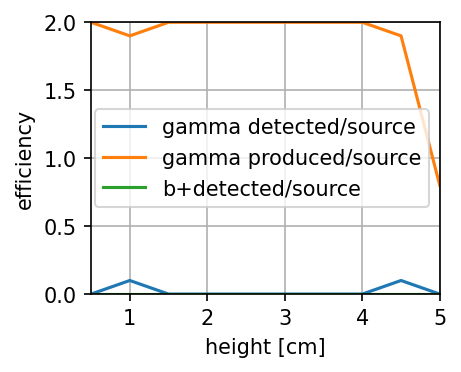

In [19]:
plt.figure(figsize=[3,2.4],dpi=150)
plt.plot([H*i for i in range(1,n+1)],g_detected,label='gamma detected/source')
plt.plot([H*i for i in range(1,n+1)],g_produced,label='gamma produced/source')
plt.plot([H*i for i in range(1,n+1)],b_detected,label=particle+'detected/source')

plt.xlabel('height [cm]')
plt.xlim([H,n*H])
plt.ylim([0,max(g_detected+g_produced+b_detected)])
plt.legend()
plt.grid()
plt.show()